In [ ]:
!pip install kora -q
from kora import drive
drive.link_nbs()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# import sys
# sys.path.append('/content/drive/MyDrive/AI_Notebooks/DLS_YSDA/Diffusion/UNetDiffusion')

#### 0) Data issues + patching + patch embeddings

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageNet, CIFAR10
from torchvision import transforms
from timm.layers import DropPath

import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange
from torch import einsum

In [ ]:
# dataset + dataloader creation (ImageNet)

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # why such values??
])

transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageNet('.', split='train', transform=transform_train)
val_dataset = ImageNet('.', split='val', transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# dataset + dataloader creation (CIFAR10)

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std for CIFAR-10
])

train_dataset = CIFAR10(root='.', train=True, download=True, transform=transform_cifar)
# val_dataset = CIFAR10(root='.', train=False, download=True, transform=transform_cifar)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 56.7MB/s]


Extracting ./cifar-10-python.tar.gz to .


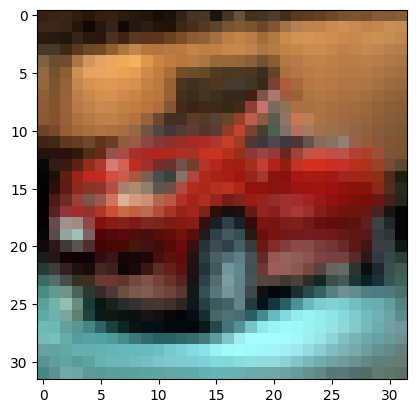

In [ ]:
tensor_image = train_dataset[45][0]

plt.imshow(tensor_image.permute(1, 2, 0));

In [ ]:
tens = torch.arange(48).view(4, 4, 3).to(torch.float)
tens

tensor([[[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [ 6.,  7.,  8.],
         [ 9., 10., 11.]],

        [[12., 13., 14.],
         [15., 16., 17.],
         [18., 19., 20.],
         [21., 22., 23.]],

        [[24., 25., 26.],
         [27., 28., 29.],
         [30., 31., 32.],
         [33., 34., 35.]],

        [[36., 37., 38.],
         [39., 40., 41.],
         [42., 43., 44.],
         [45., 46., 47.]]])

In [ ]:
def make_patches(image, patch_h, patch_w):
    """
    Extracts (patch_h)x(patch_w) patches from the input image and flattens each patch.

    Args:
    image (numpy.ndarray): Input image of shape (H, W, 3).

    Returns:
    numpy.ndarray: Output array of shape (H/4, W/4, 48).
    """

    # Ensure the image has the correct shape
    assert image.ndim == 3 and image.shape[2] == 3, "Input must be an image with shape (H, W, 3)"
    # Use einops to rearrange the image into patches and flatten them
    patches = rearrange(image, '(h h2) (w w2) c -> h w (c h2 w2)', h2=patch_h, w2=patch_w)

    return patches

In [ ]:
make_patches(tens, 2, 2)

tensor([[[ 0.,  3., 12., 15.,  1.,  4., 13., 16.,  2.,  5., 14., 17.],
         [ 6.,  9., 18., 21.,  7., 10., 19., 22.,  8., 11., 20., 23.]],

        [[24., 27., 36., 39., 25., 28., 37., 40., 26., 29., 38., 41.],
         [30., 33., 42., 45., 31., 34., 43., 46., 32., 35., 44., 47.]]])

In [ ]:
class InitLinear(nn.Module):
    def __init__(self, emb_size=32):
        super().__init__()
        self.linear = nn.Linear(in_features=12, out_features=emb_size)
        self.emb_size = emb_size

    def forward(self, x):
        # reshaping
        reshaped_input = x.view(-1, 12)
        # applying linear layer
        output = self.linear(reshaped_input)
        output = output.view(2, 2, self.emb_size)

        return output

In [ ]:
init_fc = InitLinear(emb_size=16)
patched = make_patches(tens, 2, 2)
res = init_fc(patched)

res.shape

torch.Size([2, 2, 16])

In [ ]:
init_fc.linear.weight.size()

torch.Size([16, 12])

In [ ]:
t = torch.arange(96).view(2, 2, 2, 12).to(torch.float)
t

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]],

         [[24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.],
          [36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.]]],


        [[[48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59.],
          [60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71.]],

         [[72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.],
          [84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.]]]])

In [ ]:
t = t.view(-1, 12)
t

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.],
        [24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.],
        [36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.],
        [48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59.],
        [60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71.],
        [72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.],
        [84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.]])

In [ ]:
t = t.view(2, 2, 2, 12)
t

tensor([[[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
          [12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]],

         [[24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35.],
          [36., 37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47.]]],


        [[[48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58., 59.],
          [60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71.]],

         [[72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.],
          [84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.]]]])

#### 1) Patch Embedding

In [17]:
class PatchEmbedding(nn.Module):
    """
    Splits input image into patches -> maps patches to embedding vectors

    Parameters:
        img_size (int): size of input image (supposed it comes in a square form)
        patch_size (int): length of patch's side in pixels
        emb_dim (int): dimension of aquired patch embeddings
        norm_layer (nn.Module / None): normalization to apply afterwards
    """

    def __init__(self, img_size=224, patch_size=4, emb_dim=16, norm_layer=None):
        super().__init__()
        self.patch_conv = nn.Conv2d(
            in_channels=3,
            out_channels=emb_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        self.patch_size = patch_size
        self.patches_resolution = (img_size // patch_size, img_size // patch_size)
        self.emb_dim = emb_dim
        self.norm_layer = norm_layer(emb_dim) if norm_layer is not None else None

    def forward(self, x):
        assert len(x.shape) == 4, "only batched 3d tensors supported"
        assert x.shape[3] == 3, "input tensor has to be in (H, W, 3) format"
        assert x.shape[1] % self.patch_size == 0, "tensor size has to be divisible by patch_size"

        permuted_x = x.permute(0, 3, 1, 2)      # to (bchw)
        res = self.patch_conv(permuted_x)
        res = res.permute(0, 2, 3, 1)           # back to (bhwc)
        if self.norm_layer is not None:
            res = self.norm_layer(res)

        return res

In [12]:
# tens = torch.arange(48).view(4, 4, 3).to(torch.float).unsqueeze(0)
tens = torch.randn((1, 32, 32, 3))
tens.shape

torch.Size([1, 32, 32, 3])

In [16]:
pe = PatchEmbedding(patch_size=4, emb_dim=16, norm_layer=nn.LayerNorm)

p_embs = pe(tens)
p_embs.shape

torch.Size([1, 8, 8, 16])

#### 2) Window partition + window merging

In [ ]:
p_embs.shape

torch.Size([1, 8, 8, 16])

In [ ]:
def window_partition(x, window_size=4):
    """
    Devides patched tensor into windows.

    Parameters:
        x (tensor): tensor of patches -> (B, H, W, C)
        window_size (int): size of window

    Returns:
        tensor: tensor of windows -> (n * B, window_size, window_size, C)
    """

    assert len(x.shape) == 4, "suppports only batched tensors"
    assert (x.shape[1] % window_size == 0) and (x.shape[2] % window_size == 0)

    windows = rearrange(x, 'b (h h2) (w w2) c -> (b h w) h2 w2 c', h2=window_size, w2=window_size)

    return windows


def window_merging(x, window_size, h, w):
    """
    Assembles tensor of windows into single patched tensor.

    Parameters:
        x (tensor): tensor of windows -> (n * B, window_size, window_size, C)
        window_size (int): size of window

    Returns:
        tensor: tensor of patches -> (B, H, W, C)
    """

    assert len(x.shape) == 4, "suppports only batched tensors"
    assert (x.shape[1] == window_size) and (x.shape[2] == window_size)

    h_ = h // window_size
    w_ = w // window_size

    patches = rearrange(x, '(b h w) h2 w2 c -> b (h h2) (w w2) c', h=h_, w=w_)

    return patches

In [ ]:
# check window partition shapes

print(f"{p_embs.shape=}")
wp_mine = window_partition(p_embs, 4)
print(f"{wp_mine.shape=}")

p_mine = window_merging(wp_mine, 4, 8, 8)
print(f"{p_mine.shape=}")

# tt = torch.arange(32).reshape(1, 4, 4, 2)
# ttwp = window_partition(tt, 2)
# print(f"{ttwp.shape=}")

p_embs.shape=torch.Size([1, 8, 8, 16])
wp_mine.shape=torch.Size([4, 4, 4, 16])
p_mine.shape=torch.Size([1, 8, 8, 16])


In [ ]:
# Сравнение выходов моих функций с выходами функций из офригинальной реализации

def _window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def _window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


t = torch.arange(32).reshape(1, 4, 4 , 2)
wp_1 = window_partition(t, 2)
wp_2 = _window_partition(t, 2)
p1 = window_merging(wp_1, 2, 4, 4)
p2 = _window_reverse(wp_1, 2, 4, 4)

# --> все сходится

#### 3) (MLP + WMSA) -> SWIN block

In [3]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron

    Parameters:
        in_features (int): number of input tensor's features
        hid_features (int): number of neurons at hidden layer
        out_features (int): number of neurons at output layer
        act_layer (nn.Module): activation layer
        drop (float): dropout proabbility -> (0, 1)
    """

    def __init__(self, in_features, hid_features=None, out_features=None,
                 act_layer=nn.GELU, drop=0.):
        super().__init__()
        hid_features = hid_features or in_features
        out_features = out_features or in_features

        self.fc1 = nn.Linear(in_features, hid_features)
        self.act_layer = act_layer()
        self.fc2 = nn.Linear(hid_features, out_features)
        self.drop_layer = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_layer(x)
        x = self.drop_layer(x)
        x = self.fc2(x)
        x = self.drop_layer(x)

        return x

In [4]:
class WMSA(nn.Module):
    """
    Window-based Multi-head Self Attention

    Parameters:
        input _dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        n_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        output_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, input_dim, window_size, n_heads,
                 qkv_bias=True, qk_scale=None, attn_drop=0., output_drop=0.):
        super().__init__()
        self.input_dim = input_dim
        self.window_size = window_size
        self.n_heads = n_heads
        assert input_dim % n_heads == 0    # -> to avoid errors in rearranging
        self.head_dim = input_dim // n_heads
        self.qk_scale = qk_scale or self.head_dim ** -0.5

        self.to_qkv = nn.Conv2d(input_dim, self.n_heads * self.head_dim * 3, 1, bias=qkv_bias)
        self.to_out = nn.Conv2d(self.n_heads * self.head_dim, input_dim, 1)
        self.attn_drop = nn.Dropout(attn_drop)
        self.output_drop = nn.Dropout(output_drop)

        # define a parameter table of Relative Position Bias
        self.rpb_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), n_heads)   # (2*Wh-1 * 2*Ww-1, nH)
        )

        # constructing Relative Position Bias index matrix
        # absolute coords:
        x_coords = torch.arange(window_size[0])
        y_coords = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid(x_coords, y_coords, indexing='ij'), axis=0)
        coords_flat = coords.flatten(start_dim=1)
        # relative coords:
        coords_rel = coords_flat.unsqueeze(2) - coords_flat.unsqueeze(1)
        coords_rel = coords_rel.permute(1, 2, 0).contiguous()
        coords_rel[:, :, 0] += window_size[0] - 1
        coords_rel[:, :, 1] += window_size[1] - 1
        coords_rel[:, :, 0] *= 2 * window_size[1] - 1
        self.relative_position_index = coords_rel.sum(-1)


    def forward(self, x, mask=None):
        x = x.permute(0, 3, 1, 2)               # -> (bW, C, Wh, Ww)
        bW, c, Wh, Ww = x.shape                 # bW = b * nW

        qkv = self.to_qkv(x).chunk(3, dim=1)    # -> 3 x (bW, C, Wh, Ww)

        q, k, v = map(
            lambda t: rearrange(t, "b (h d) x y -> b h d (x y)", h=self.n_heads), qkv
        )
        q = q * self.qk_scale    # -> (bW, nH, C, Wh*Ww)  for q, k, v

        sim = einsum("b h d i, b h d j -> b h i j", q, k)    # -> (bW, nH, Wh*Ww, Wh*Ww)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()

        rpb = self.rpb_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1   # -> (Wh*Ww, Wh*Ww, nH)
        )

        rpb = rpb.permute(2, 0, 1).contiguous()           # -> (nH, Wh*Ww, Wh*Ww)
        sim = sim + rpb.unsqueeze(0)                      # rpb -> (1, nH, Wh*Ww, Wh*Ww)
        if mask is not None:
            nW = mask.shape[0]                            # -> n of windows in single img
            sim = rearrange(sim, "(b nW) nH i j -> b nW nH i j", nW=nW)
            sim = sim + mask.unsqueeze(1).unsqueeze(0)    # mask -> (1, nW, 1, Wh*Ww, Wh*Ww)
        attn = sim.softmax(dim=-1)
        if mask is not None:
            attn = rearrange(attn, "b nW nH i j -> (b nW) nH i j")

        output = einsum("b h i j, b h d j -> b h i d", attn, v)                 # -> (bW, nH, Wh*Ww, C)
        output = rearrange(output, "b h (x y) d -> b (h d) x y", x=Wh, y=Ww)    # -> (bW, C, Wh, Ww)
        output = self.to_out(output)
        output = output.permute(0, 2, 3, 1)                                     # -> (bW, Wh, Ww, C)

        return output

In [ ]:
# WMSA check

# mock mask
mmask = torch.ones(8, 4, 4)
mmask.masked_fill(mmask != 0, float(-100.0)).masked_fill(mmask == 0, float(0.0))

t = torch.arange(96).view(2, 4, 4, 3).to(torch.float)
w = window_partition(t, window_size=2)
print(f'{w.shape=}')
wattn = WMSA(input_dim=3, window_size=(2, 2), n_heads=1)
res = wattn(w, mmask)
# res.shape

w.shape=torch.Size([8, 2, 2, 3])
attn shape final torch.Size([1, 8, 1, 4, 4])


In [ ]:
t = torch.randn(2, 16)  # 16 = 4 * 4
(t.unsqueeze(1) - t.unsqueeze(2)).shape

torch.Size([2, 16, 16])

In [ ]:
# Relative Position Bias
Wh = 4
Ww = 4
window_size = (Wh, Ww)

x_coords = torch.arange(window_size[0])
y_coords = torch.arange(window_size[1])
coords = torch.stack(torch.meshgrid(x_coords, y_coords), axis=0)
coords_flat = coords.flatten(start_dim=1)
coords_rel = coords_flat.unsqueeze(2) - coords_flat.unsqueeze(1)
coords_rel = coords_rel.permute(1, 2, 0).contiguous()
coords_rel[:, :, 0] += window_size[0] - 1
coords_rel[:, :, 1] += window_size[1] - 1
coords_rel[:, :, 0] *= 2 * window_size[1] - 1
relative_position_index = coords_rel.sum(-1)

relative_position_index.shape

torch.Size([16, 16])

In [ ]:
# qkv -> [torch.Size([8, 3, 2, 2]), torch.Size([8, 3, 2, 2]), torch.Size([8, 3, 2, 2])]

In [5]:
def build_mask(resolution, winsize, shift):
    """
    Constructs boolean mask for WMSA.

    Parameters:
        resolution (Tuple[int, int]): height and width of input tensor
        winsize (int): size of window
        shift (int): number of patches to move up and left
    """
    h, w = resolution
    mask = torch.zeros((1, h, w, 1))

    h_stamps = (0, -winsize, -shift)
    w_stamps = (0, -winsize, -shift)

    for hs in h_stamps:
        mask[:, hs:, :, :] += 1
    for ws in w_stamps:
        mask[:, :, ws:, :] += 3

    mask = window_partition(mask, window_size=winsize)    # -> (nW, Wh, Ww, 1)
    mask = mask.flatten(start_dim=1)                      # -> (nW, Wh*Ww)
    attn_mask = mask.unsqueeze(1) - mask.unsqueeze(2)     # -> (nW, (Wh*ww)*(Wh*Ww))
    attn_mask = (attn_mask != 0).float() * -100.0

    return attn_mask

In [6]:
class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer Block

    Parameters:
        input_dim (int): number of channels in input tensor
        input_resolution (Tuple[int]): input resulotion
        n_heads (int): number of attentions heads
        window_size (int): window size
        shift_size (int): shift size for SW-MSA.
        mlp_ratio (float): ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        mlp_drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_dim, input_resolution, n_heads,
                 window_size=7, shift_size=2, mlp_ratio=4., qkv_bias=True,
                 qk_scale=None, mlp_drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_dim = input_dim
        self.input_resolution = input_resolution    # нужно передать, чтобы создать маску без входной картинки
        self.n_heads = n_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        # if window is larger than the image - we work with only one window and do no shifts
        if min(self.input_resolution) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)

        self.norm1 = norm_layer(input_dim)
        self.attn = WMSA(input_dim=input_dim, window_size=(window_size, window_size),
                         n_heads=n_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                         attn_drop=attn_drop, output_drop=mlp_drop)
        self.norm2 = norm_layer(input_dim)
        mlp_hidden_dim = int(input_dim * mlp_ratio)
        self.mlp = MLP(in_features=input_dim, hid_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=mlp_drop)


        # building mask
        if self.shift_size > 0:
            self.attn_mask = build_mask(resolution=self.input_resolution,
                                        winsize=self.window_size,
                                        shift=self.shift_size)
        else:
            self.attn_mask = None

        self.drop_path = DropPath(drop_path)

    def forward(self, x):    # x -> (B, H, W, C)
        B, H, W, C = x.shape

        residual = x
        x = self.norm1(x.view(B, H*W, C))
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            x_shifted = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            x_shifted = x

        # window partition
        x_windows = window_partition(x_shifted, self.window_size)    # -> (bW, Wh, Ww, C)

        # WMSA with shifts
        attn_windows = self.attn(x_windows, mask=self.attn_mask)     # -> (bW, Wh, Ww, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            x_shifted = window_merging(attn_windows, self.window_size, H, W)    # -> (B, H, W, C)
            x = torch.roll(x_shifted, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            shifted_x = window_merging(attn_windows, self.window_size, H, W)    # -> (B, H, W, C)
            x = shifted_x

        x = x + residual
        x = x.view(B, H * W, C)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        x = x.view(B, H, W, C)

        return x

In [ ]:
tens = torch.randn((6, 32, 32, 3))

pe = PatchEmbedding(patch_size=4, emb_dim=48)
p_embs = pe(tens)
print(f'{p_embs.shape=}')    # -> (2, 8, 8, 16)

swt = SwinTransformerBlock(
    input_dim=48, input_resolution=(8, 8), n_heads=6,
    window_size=4, shift_size=2
)

swt_out = swt(p_embs)
print(f'{swt_out.shape=}')

p_embs.shape=torch.Size([6, 8, 8, 48])
qkv[0].shape=torch.Size([24, 48, 4, 4])
swt_out.shape=torch.Size([6, 8, 8, 48])


#### 4) Patch merging

In [7]:
class PatchMerging(nn.Module):
    """
    Patch Merging (downsampling method)

    Parameters:
        input_dim (int): number of channels in input tensor
        norm_layer (nn.Module, optional): normalization to apply before merging
    """

    def __init__(self, input_dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_dim = input_dim
        self.reduction = nn.Conv2d(input_dim, 2 * input_dim, kernel_size=2, stride=2, bias=False)
        self.norm_layer = norm_layer(input_dim)

    def forward(self, x):    # x -> (B, H, W, C)
        x = self.norm_layer(x)
        x = x.permute(0, 3, 1, 2)   # -> (B, C, H, W)
        x = self.reduction(x)
        x = x.permute(0, 2, 3, 1)   # -> (B, H, W, C)

        return x

In [ ]:
tens = torch.randn((6, 32, 32, 3))
pe = PatchEmbedding(patch_size=4, emb_dim=48)
p_embs = pe(tens)

swt = SwinTransformerBlock(
    input_dim=48, input_resolution=(8, 8), n_heads=6,
    window_size=4, shift_size=2
)

swt_out = swt(p_embs)
print(f'{swt_out.shape=}')

pm = PatchMerging(input_dim=48)
pm_out = pm(swt_out)
print(f'{pm_out.shape=}')

qkv[0].shape=torch.Size([24, 48, 4, 4])
swt_out.shape=torch.Size([6, 8, 8, 48])
pm_out.shape=torch.Size([6, 4, 4, 96])


#### 5) Basic Layer -> full arch

In [8]:
class BasicLayer(nn.Module):
    """
    Basic Swin Transformer layer.
    Stacks several Swin Blocks and puts the downsampler afterwords.

    Parameters:
        input_dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        n_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of MLP hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        mlp_drop (float, optional): MLP dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
    """

    def __init__(self, input_dim, input_resolution, depth, n_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, mlp_drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None):
        super().__init__()
        self.input_dim = input_dim
        self.input_resolution = input_resolution
        self.depth = depth

        # SWIN blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(
                input_dim=input_dim, input_resolution=input_resolution,
                n_heads=n_heads, window_size=window_size,
                shift_size=0 if (i % 2 == 0) else window_size // 2,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                mlp_drop=mlp_drop, attn_drop=attn_drop,
                drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                norm_layer=norm_layer
            )
            for i in range(depth)
        ])

        # downsampling
        if downsample is not None:
            self.downsample = downsample(input_dim=input_dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        if self.downsample is not None:
            x = self.downsample(x)

        return x

In [ ]:
# BasicLayer checking
tens = torch.randn((6, 64, 64, 3))
pe = PatchEmbedding(patch_size=4, emb_dim=48)
pm = PatchMerging(input_dim=48)

p_embs = pe(tens)
print(f'{p_embs.shape=}')

bl = BasicLayer(
    input_dim=48, input_resolution=(16, 16), depth=3,
    n_heads=6, window_size=4, downsample=PatchMerging
)

blayer_out = bl(p_embs)
print(f'{blayer_out.shape=}')

p_embs.shape=torch.Size([6, 16, 16, 48])
blayer_out.shape=torch.Size([6, 8, 8, 96])


In [ ]:
class SwinTransformer(nn.Module):
    """
    SWIN Transformer

    Parameters:
        img_size (int): image size
        patch_size (int): patch size
        input_dim (int): number of channels in input image
        n_classes (int): number of classes for classification
        emb_dim (int): embedding dimension
        depths (List[int]): number of Swin Blocks in each Basic Layer
        n_heads (List[int]): number of attn heads in each Basic Layer
        window_size (int): window size
        mlp_ratio (float): ratio of MLP hidden dim to embedding dim
        qkv_bias (bool, optional): if True, add a learnable bias to query, key, value
        qk_scale (float | None, optional): override default qk scale of head_dim ** -0.5 if set
        mlp_drop (float, optional): MLP dropout rate. Default: 0.0
        attn_drop (float, optional): attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): normalization to apply after feature extraction
        patch_norm (nn.Module, optional): normalization for PatchEmbedding layer

    """

    def __init__(self, img_size=224, patch_size=4, input_dim=3, n_classes=1000,
                 emb_dim=96, depths=[2, 2, 6, 2], n_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 mlp_drop=0., attn_drop=0., drop_path=0.1,
                 norm_layer=nn.LayerNorm, patch_norm=True, **kwargs):
        super().__init__()

        self.n_classes = n_classes
        self.n_layers = len(depths)
        self.emb_dim = emb_dim
        self.patch_norm = patch_norm
        self.num_features = int(emb_dim * 2 ** (self.n_layers - 1))
        self.mlp_ratio = mlp_ratio

        self.patch_embed = PatchEmbedding(patch_size=patch_size, emb_dim=emb_dim,
                                          norm_layer=norm_layer if self.patch_norm else None)
        patches_resolution = self.patch_embed.patches_resolution

        # stochastic depth decay
        dpr = [x.item() for x in torch.linspace(0, drop_path, sum(depths))]

        # basic layers
        self.layers = nn.ModuleList([
            BasicLayer(dim=int(emb_dim * 2 ** i),
                        input_resolution=(patches_resolution[0] // (2 ** i),
                                          patches_resolution[1] // (2 ** i)),
                        depth=depths[i],
                        num_heads=n_heads[i],
                        window_size=window_size,
                        mlp_ratio=self.mlp_ratio,
                        qkv_bias=qkv_bias, qk_scale=qk_scale,
                        mlp_drop=mlp_drop, attn_drop=attn_drop,
                        drop_path=dpr[sum(depths[:i]):sum(depths[:i + 1])],
                        norm_layer=norm_layer,
                        downsample=PatchMerging if (i < self.n_layers - 1) else None)
            for i in range(self.n_layers)
        ])

        self.norm = norm_layer(self.num_features)
        # self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, n_classes) if n_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def extract_features(self, x):
        x = self.patch_embed(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        # x = self.avgpool(x.transpose(1, 2))
        x = torch.flatten(x, 1)

        return x

    def forward(self, x):
        x = self.extract_features(x)
        x = self.head(x)

        return x

    def _init_weights(self, m):
        # if isinstance(m, nn.Linear):
        #     trunc_normal_(m.weight, std=.02)
        #     if isinstance(m, nn.Linear) and m.bias is not None:
        #         nn.init.constant_(m.bias, 0)
        # elif isinstance(m, nn.LayerNorm):
        #     nn.init.constant_(m.bias, 0)
        #     nn.init.constant_(m.weight, 1.0)
        pass


#### Trials:

In [ ]:
def build_mask(resolution, winsize, shift):
    h, w = resolution
    mask = torch.zeros((1, h, w, 1))

    # h_stamps = (0, -winsize, -shift, None)
    # w_stamps = (0, -winsize, -shift, None)
    # h_slices = [slice(*x) for x in zip(h_stamps[:-1], h_stamps[1:])]
    # w_slices = [slice(*x) for x in zip(w_stamps[:-1], w_stamps[1:])]

    # h_slices = (
    #     slice(0, -winsize),
    #     slice(-winsize, -shift),
    #     slice(-shift, None)
    # )

    # w_slices = (
    #     slice(0, -winsize),
    #     slice(-winsize, -shift),
    #     slice(-shift, None)
    # )

    # for hs in h_slices:
    #     mask[:, hs, :, :] += 1
    # for ws in w_slices:
    #     mask[:, :, ws, :] += 1

    h_stamps = (0, -winsize, -shift)
    w_stamps = (0, -winsize, -shift)
    for hs in h_stamps:
        mask[:, hs:, :, :] += 1
    for ws in w_stamps:
        mask[:, :, ws:, :] += 3

    mask = window_partition(mask, window_size=winsize)    # -> (nW, Wh, Ww, 1)
    mask = mask.flatten(start_dim=1)                      # -> (nW, Wh*Ww)
    attn_mask = mask.unsqueeze(1) - mask.unsqueeze(2)     # -> (nW, (Wh*ww)*(Wh*Ww))
    attn_mask = (attn_mask != 0).float() * -100.0

    return attn_mask

In [ ]:
# # numbers:
# tensor([[ 4.,  4.,  4.,  4.,  7.,  7., 10., 10.],
#         [ 4.,  4.,  4.,  4.,  7.,  7., 10., 10.],
#         [ 4.,  4.,  4.,  4.,  7.,  7., 10., 10.],
#         [ 4.,  4.,  4.,  4.,  7.,  7., 10., 10.],
#         [ 5.,  5.,  5.,  5.,  8.,  8., 11., 11.],
#         [ 5.,  5.,  5.,  5.,  8.,  8., 11., 11.],
#         [ 6.,  6.,  6.,  6.,  9.,  9., 12., 12.],
#         [ 6.,  6.,  6.,  6.,  9.,  9., 12., 12.]])

[slice(0, -4, None), slice(-4, -2, None), slice(-2, None, None)]

In [ ]:
def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)

    return x * random_tensor

In [ ]:
-0 == 0

True

In [ ]:
c = 5
b = 6
a = b or c

a

6